In [19]:
import gc
import matplotlib.pyplot as plt
plt.close('all')
gc.collect()
print("Memoria liberada.")

Memoria liberada.


       📊 LOG DE AUDITORÍA: CARGA Y CLIPPING
Caso Analizado           : ATM_002
Ruta Imagen              : ./TrainBatch1/imagesTr\ATM_002_0000.nii.gz
Ruta Label               : ./TrainBatch1/labelsTr\ATM_002_0000.nii.gz
Dimensión del Volumen    : (512, 512, 635)
Espaciado (mm)           : (np.float32(0.744), np.float32(0.744), np.float32(0.5))
HU Mín (Original)        : -1024.0
HU Máx (Original)        : 2247.0
HU Mín (Clipped)         : -1024.0
HU Máx (Clipped)         : 600.0
Rango de Clipping        : [-1024, 600] HU


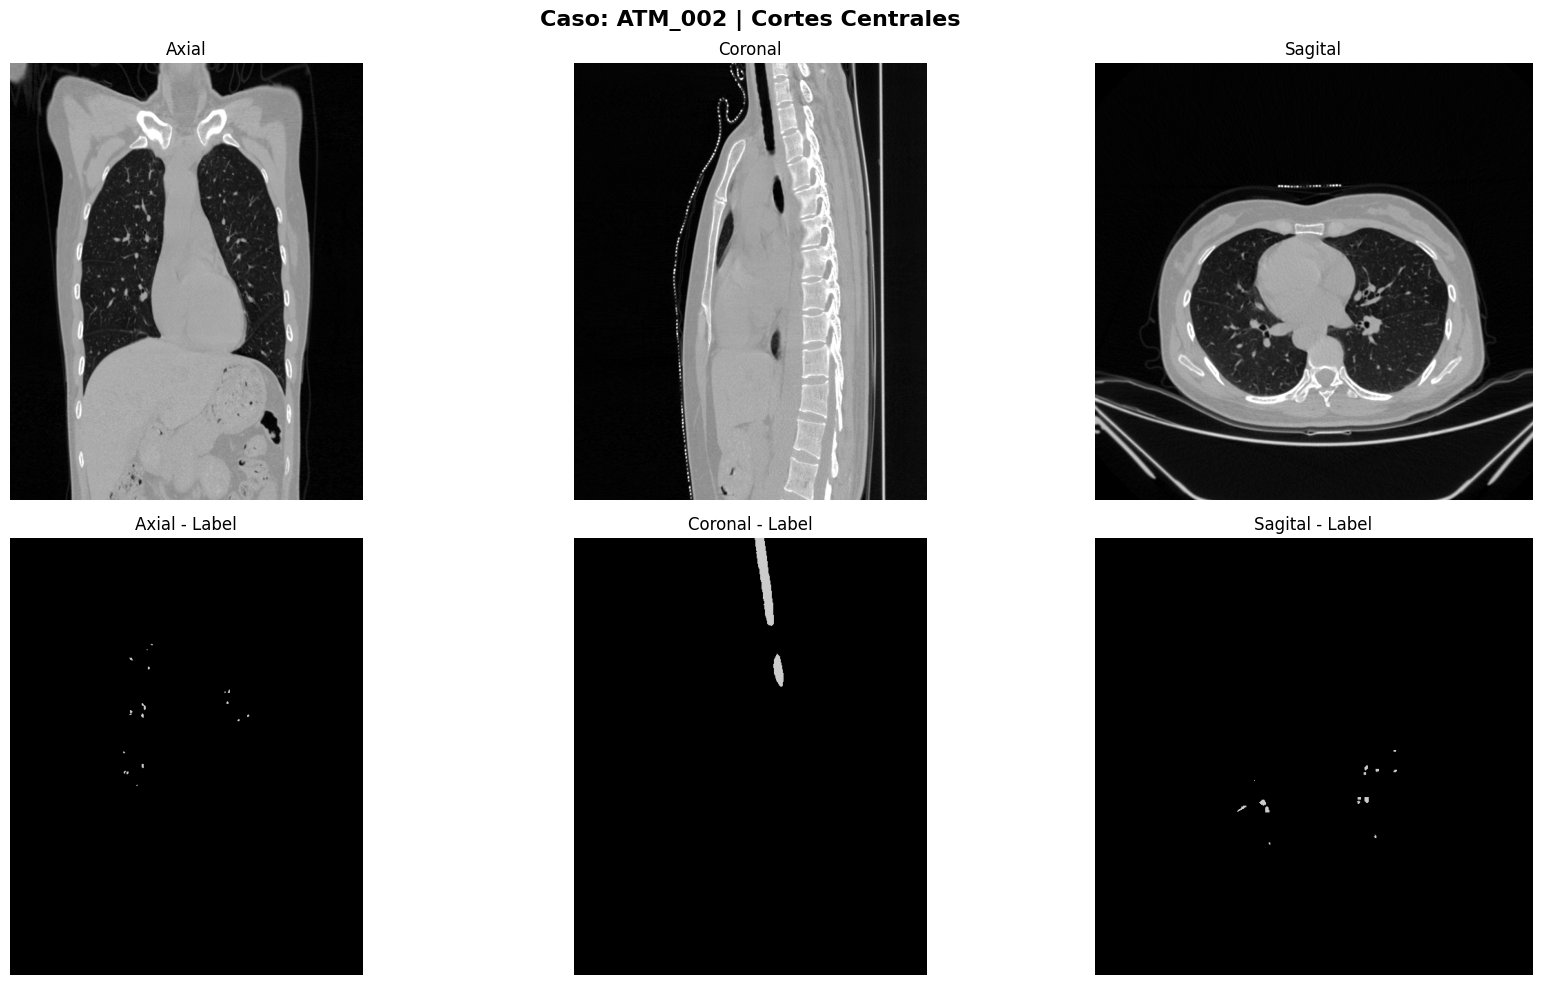

In [20]:
"""
ROI - Carga, HU Clipping y Visualización de un Volumen Único
Carga el primer volumen del ATM'22, aplica HU Clipping y lo prepara para la generación de ROI.
Proporciona un log de auditoría y una visualización estática en los tres planos.
"""

import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

# === 1. Configuración ===
# Rutas relativas: el notebook y TrainBatch1 están en el mismo directorio
DATA_PATHS = {
    "images_batch1": r"./TrainBatch1/imagesTr",
    "labels_batch1": r"./TrainBatch1/labelsTr",
    # "images_batch2": r"./TrainBatch2/imagesTr",  # Comentado: no está disponible
    # "labels_batch2": r"./TrainBatch2/labelsTr"   # Comentado: no está disponible
}

# Parámetros de HU Clipping (deben coincidir con el pipeline)
HU_MIN, HU_MAX = -1024, 600

# === 2. Selección del primer caso ===
# Solo se usa batch1
batch_key = "batch1"
images_dir = DATA_PATHS[f"images_{batch_key}"]
labels_dir = DATA_PATHS[f"labels_{batch_key}"]

# Selecciona la PRIMERA imagen (ordenada alfabéticamente)
image_files = sorted([f for f in os.listdir(images_dir) if f.endswith(".nii.gz")])
if not image_files:
    raise FileNotFoundError(f"No se encontraron imágenes en {images_dir}")

selected_image = image_files[1]  # Siempre el primero
case_id = selected_image.replace("_0000.nii.gz", "")

# Encuentra el label correspondiente
label_files = [f for f in os.listdir(labels_dir) if f.startswith(case_id) and f.endswith(".nii.gz")]
if not label_files:
    raise FileNotFoundError(f"No se encontró label para el caso '{case_id}' en {labels_dir}")
selected_label = label_files[0]

img_path = os.path.join(images_dir, selected_image)
lbl_path = os.path.join(labels_dir, selected_label)

# === 3. Carga y preprocesamiento ===
# Carga la imagen y el label
img_nii = nib.load(img_path)
vol_orig = img_nii.get_fdata(dtype=np.float32)
affine, header = img_nii.affine, img_nii.header

lbl_nii = nib.load(lbl_path)
vol_label = lbl_nii.get_fdata().astype(np.uint8)

# Aplica HU Clipping para generar `vol_clip` (entrada requerida por Cell 2-3)
vol_clip = np.clip(vol_orig, HU_MIN, HU_MAX)

# === 4. Generación del Log de Auditoría ===
audit_log = {
    "Caso Analizado": case_id,
    "Ruta Imagen": img_path,
    "Ruta Label": lbl_path,
    "Dimensión del Volumen": vol_orig.shape,
    "Espaciado (mm)": tuple(round(s, 3) for s in header.get_zooms()),
    "HU Mín (Original)": float(vol_orig.min()),
    "HU Máx (Original)": float(vol_orig.max()),
    "HU Mín (Clipped)": float(vol_clip.min()),
    "HU Máx (Clipped)": float(vol_clip.max()),
    "Rango de Clipping": f"[{HU_MIN}, {HU_MAX}] HU"
}

print("=" * 50)
print("       📊 LOG DE AUDITORÍA: CARGA Y CLIPPING")
print("=" * 50)
for key, value in audit_log.items():
    print(f"{key:<25}: {value}")
print("=" * 50)

# === 5. Visualización Estática en los Tres Planos Centrales ===
# Obtener los índices centrales
z_mid = vol_clip.shape[0] // 2
y_mid = vol_clip.shape[1] // 2
x_mid = vol_clip.shape[2] // 2

# Extraer y rotar los cortes centrales
axial_vol   = np.rot90(vol_clip[:, y_mid, :], k=1)
coronal_vol = np.rot90(vol_clip[z_mid, :, :], k=1)
sagittal_vol = np.rot90(vol_clip[:, :, x_mid], k=-1)

axial_lbl   = np.rot90(vol_label[:, y_mid, :], k=1)
coronal_lbl = np.rot90(vol_label[z_mid, :, :], k=1)
sagittal_lbl = np.rot90(vol_label[:, :, x_mid], k=-1)

# Crear la figura
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle(f"Caso: {case_id} | Cortes Centrales", fontsize=16, weight='bold')

# Panel 1: TC con HU Clipping
axes[0, 0].imshow(axial_vol, cmap="gray", vmin=-1024, vmax=600)
axes[0, 0].set_title("Axial", fontsize=12)
axes[0, 0].axis("off")

axes[0, 1].imshow(coronal_vol, cmap="gray", vmin=-1024, vmax=600)
axes[0, 1].set_title("Coronal", fontsize=12)
axes[0, 1].axis("off")

axes[0, 2].imshow(sagittal_vol, cmap="gray", vmin=-1024, vmax=600)
axes[0, 2].set_title("Sagital", fontsize=12)
axes[0, 2].axis("off")

# Panel 2: Label Manual (Ground Truth)
axes[1, 0].imshow(axial_lbl, cmap="nipy_spectral", vmin=0, vmax=vol_label.max())
axes[1, 0].set_title("Axial - Label", fontsize=12)
axes[1, 0].axis("off")

axes[1, 1].imshow(coronal_lbl, cmap="nipy_spectral", vmin=0, vmax=vol_label.max())
axes[1, 1].set_title("Coronal - Label", fontsize=12)
axes[1, 1].axis("off")

axes[1, 2].imshow(sagittal_lbl, cmap="nipy_spectral", vmin=0, vmax=vol_label.max())
axes[1, 2].set_title("Sagital - Label", fontsize=12)
axes[1, 2].axis("off")

plt.tight_layout()
plt.show()

[Cell 2-3] ROI → voxeles=11120431, componentes=1, semillas=231


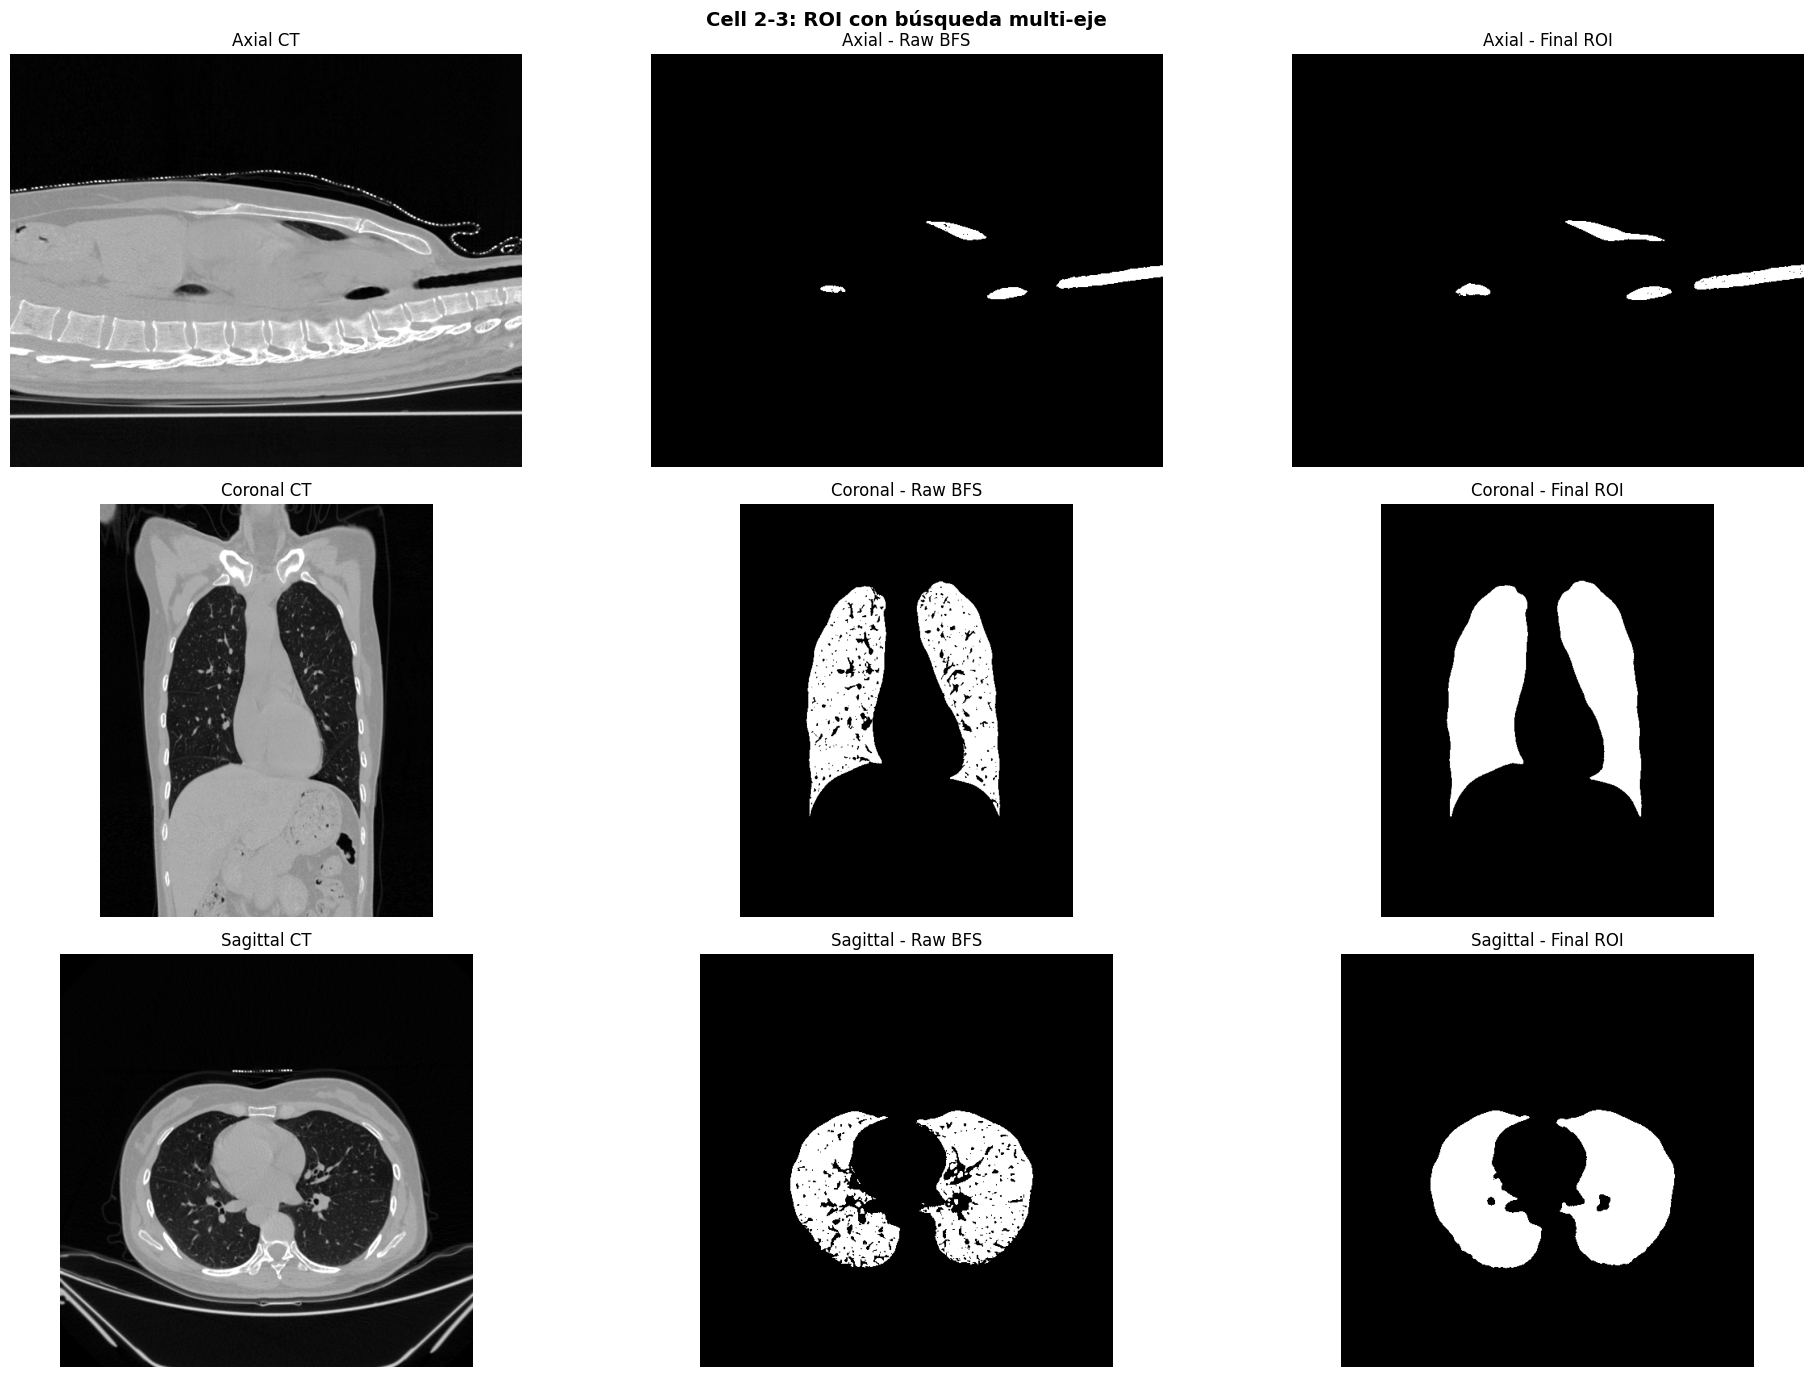

In [21]:
# =========================
# Búsqueda multi-eje + visualización completa
# =========================

import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import remove_small_objects, binary_closing, binary_dilation, ball
from skimage.segmentation import clear_border
from scipy.ndimage import label as cc_label, binary_fill_holes
from collections import deque

assert 'vol_clip' in globals(), "vol_clip no encontrado. Ejecuta la Cell 1."

# --- Parámetros optimizados ---
AIR_THR_STRICT = -950
GROW_THR = -700
MIN_SIZE = 50
SMOOTH_RADIUS = 5

Z, Y, X = vol_clip.shape

# --- Paso 1: Semillas con búsqueda multi-eje ---
seeds = (vol_clip <= AIR_THR_STRICT)
seeds = clear_border(seeds)
seeds = remove_small_objects(seeds, min_size=MIN_SIZE)

# ✅ Regiones de búsqueda para cada eje
delta_z = Z // 10
delta_y = Y // 8
delta_x = X // 8

# Axial: alrededor de Z//2
axial_region = np.zeros_like(seeds, dtype=bool)
z_axial = Z // 2
axial_region[max(0, z_axial - delta_z):min(Z, z_axial + delta_z), :, :] = True

# Coronal: alrededor de Y//2
coronal_region = np.zeros_like(seeds, dtype=bool)
y_coronal = Y // 2
coronal_region[:, max(0, y_coronal - delta_y):min(Y, y_coronal + delta_y), :] = True

# Sagittal: alrededor de X//2
sagittal_region = np.zeros_like(seeds, dtype=bool)
x_sagittal = X // 2
sagittal_region[:, :, max(0, x_sagittal - delta_x):min(X, x_sagittal + delta_x)] = True

# ✅ Intersección de regiones
search_region = axial_region & coronal_region & sagittal_region
trachea_cand = seeds & search_region

# --- Detección de tráquea ---
trachea = np.zeros_like(seeds, dtype=bool)
labeled_top, n_top = cc_label(trachea_cand)

if n_top > 0:
    sizes = np.bincount(labeled_top.ravel())
    sizes[0] = 0
    main_label = np.argmax(sizes)
    trachea = (labeled_top == main_label)

# --- BFS optimizado ---
airways_mask = np.zeros_like(seeds, dtype=np.uint8)
seed_pts = np.argwhere(trachea)

if len(seed_pts) > 0:
    q = deque(seed_pts[:100])
    for pt in seed_pts[:100]:
        airways_mask[tuple(pt)] = 1

    neighbors = [(1,0,0), (-1,0,0), (0,1,0), (0,-1,0), (0,0,1), (0,0,-1)]
    while q:
        z, y, x = q.popleft()
        for dz, dy, dx in neighbors:
            nz, ny, nx = z + dz, y + dy, x + dx
            if (0 <= nz < Z and 0 <= ny < Y and 0 <= nx < X and 
                airways_mask[nz, ny, nx] == 0 and vol_clip[nz, ny, nx] <= GROW_THR):
                airways_mask[nz, ny, nx] = 1
                q.append((nz, ny, nx))

# --- Componente conectada ---
labeled_airways, n_airways = cc_label(airways_mask)
if n_airways > 0 and len(seed_pts) > 0:
    sz, sy, sx = seed_pts[0]
    seed_label = labeled_airways[sz, sy, sx]
    airways_mask = (labeled_airways == seed_label).astype(np.uint8)

# --- Post-procesamiento ---
mask_raw = airways_mask.astype(bool)
mask_clean = remove_small_objects(mask_raw, min_size=MIN_SIZE)
mask_closed = binary_closing(mask_clean, footprint=ball(SMOOTH_RADIUS))
mask_filled = binary_fill_holes(mask_closed)

from skimage.morphology import binary_closing as sk_binary_closing
mask_closed3d = sk_binary_closing(mask_filled, footprint=ball(2))
mask_dilated = binary_dilation(mask_closed3d, footprint=ball(1))
final_roi = binary_fill_holes(mask_dilated).astype(np.uint8)

# --- Eliminar fondo ---
final_roi[vol_clip == -1000] = 0

# --- Auditoría ---
voxels = int(final_roi.sum())
components = cc_label(final_roi)[1]
print(f"[Cell 2-3] ROI → voxeles={voxels}, componentes={components}, semillas={len(seed_pts)}")

# --- Visualización en las 3 vistas ---
zmid, ymid, xmid = Z//2, Y//2, X//2

fig, ax = plt.subplots(3, 3, figsize=(20, 14))

# Axial
ax[0,0].imshow(vol_clip[zmid], cmap='gray'); ax[0,0].set_title("Axial CT"); ax[0,0].axis("off")
ax[0,1].imshow(mask_raw[zmid], cmap='gray'); ax[0,1].set_title("Axial - Raw BFS"); ax[0,1].axis("off")
ax[0,2].imshow(final_roi[zmid], cmap='gray'); ax[0,2].set_title("Axial - Final ROI"); ax[0,2].axis("off")

# Coronal
ax[1,0].imshow(np.rot90(vol_clip[:, ymid, :],1), cmap='gray'); ax[1,0].set_title("Coronal CT"); ax[1,0].axis("off")
ax[1,1].imshow(np.rot90(mask_raw[:, ymid, :],1), cmap='gray'); ax[1,1].set_title("Coronal - Raw BFS"); ax[1,1].axis("off")
ax[1,2].imshow(np.rot90(final_roi[:, ymid, :],1), cmap='gray'); ax[1,2].set_title("Coronal - Final ROI"); ax[1,2].axis("off")

# Sagittal
ax[2,0].imshow(np.rot90(vol_clip[:,:,xmid],-1), cmap='gray'); ax[2,0].set_title("Sagittal CT"); ax[2,0].axis("off")
ax[2,1].imshow(np.rot90(mask_raw[:,:,xmid],-1), cmap='gray'); ax[2,1].set_title("Sagittal - Raw BFS"); ax[2,1].axis("off")
ax[2,2].imshow(np.rot90(final_roi[:,:,xmid],-1), cmap='gray'); ax[2,2].set_title("Sagittal - Final ROI"); ax[2,2].axis("off")

plt.suptitle("Cell 2-3: ROI con búsqueda multi-eje", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()


[Cell 4 TUBULAR] Umbrales: AIR_THR_STRICT=-980.0, GROW_THR=-888.0
[Cell 4 TUBULAR] Airways auto → voxeles=116271, componentes=1, seed_trachea_pts=22136


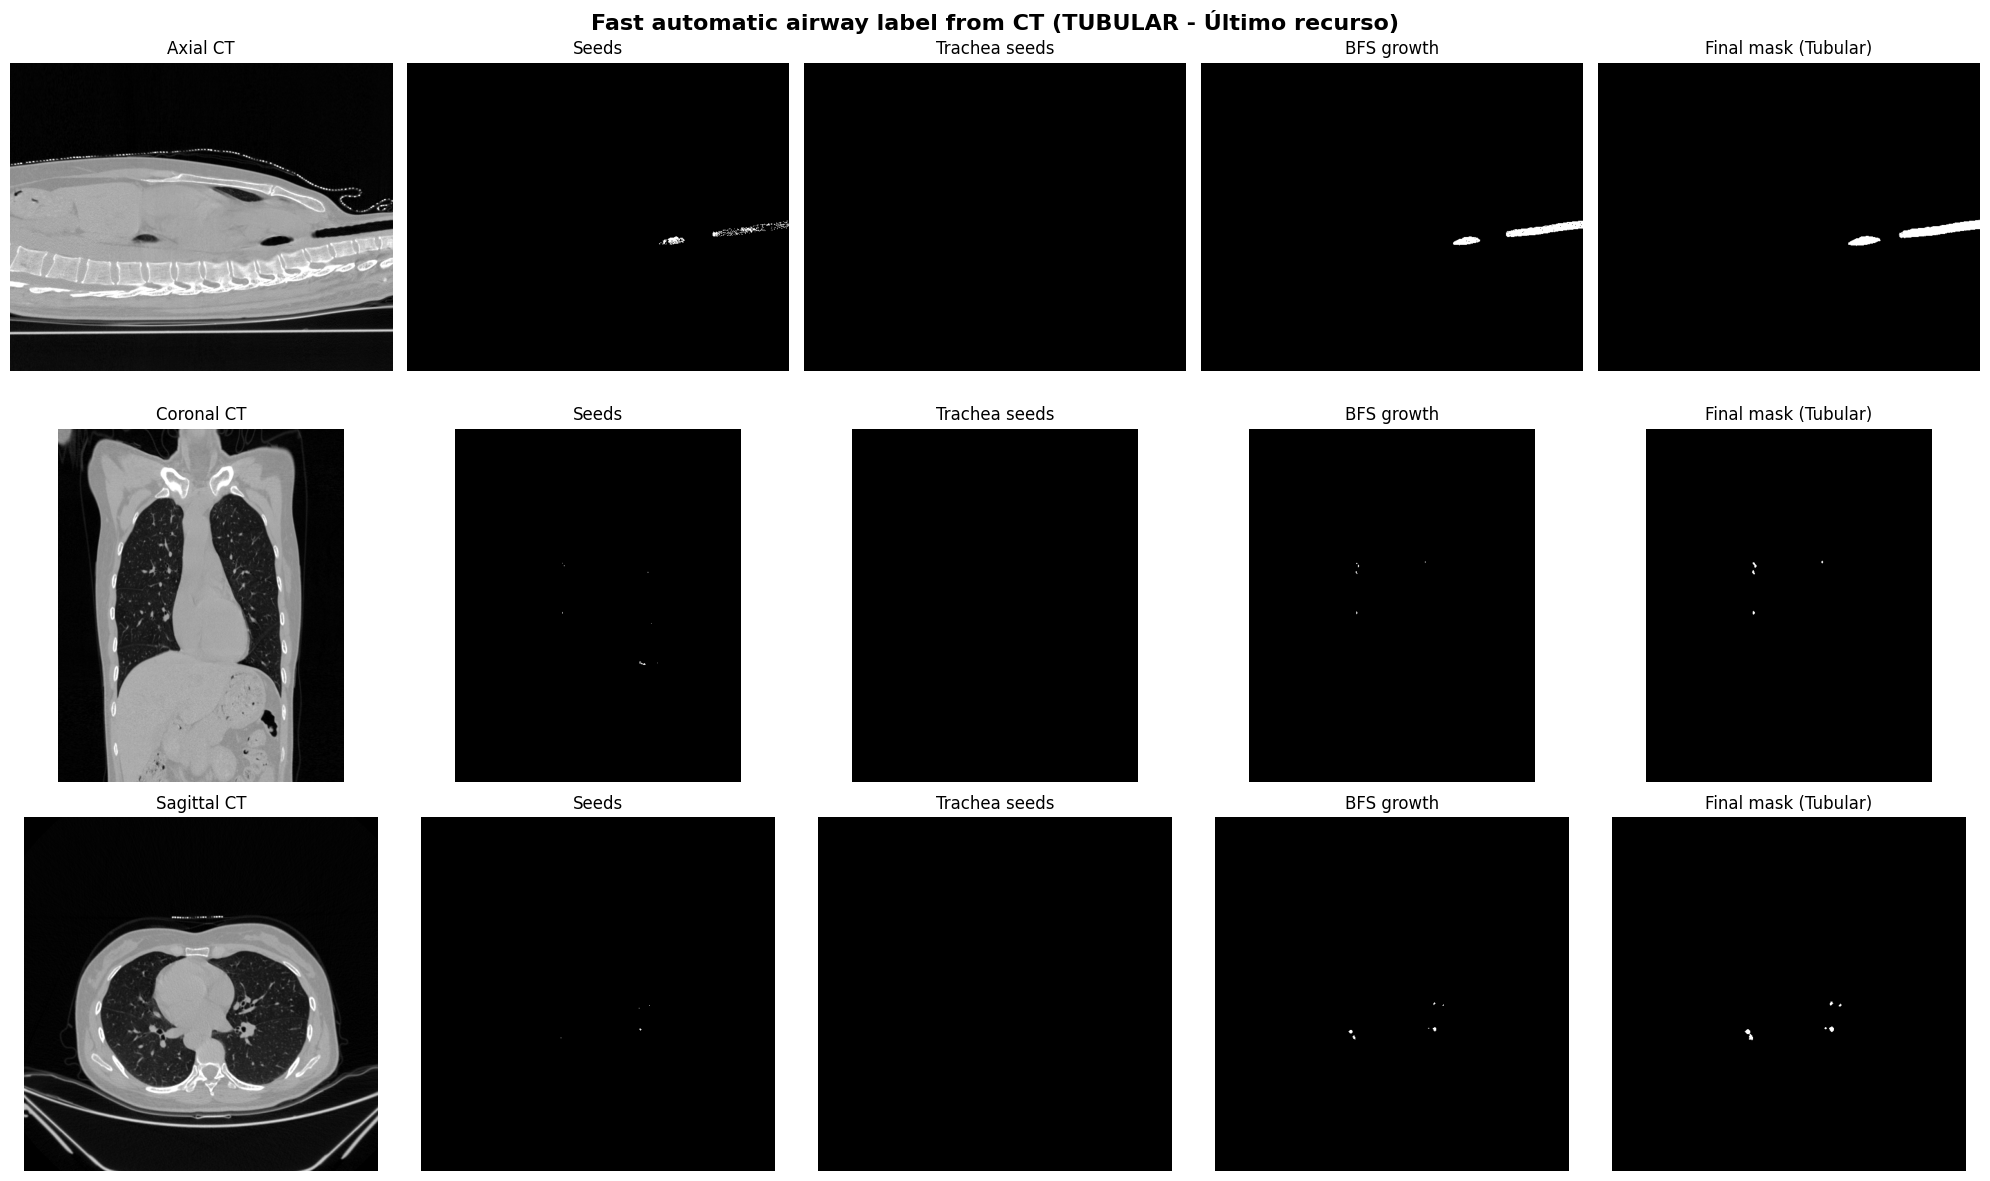

In [22]:
# =========================
# Fast automatic airway label from CT only (TUBULAR)
# =========================

import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import ball
from scipy.ndimage import label as cc_label, binary_dilation, binary_closing
from collections import deque

# --- Preconditions ---
assert 'vol_clip' in globals(), "vol_clip no encontrado. Ejecuta la Cell 1."
assert 'final_roi' in globals(), "final_roi no encontrado. Ejecuta la Cell 2-3."

# --- Step 0: Calcular umbrales adaptativos más estrictos ---
roi_hu_values = vol_clip[final_roi > 0]
GROW_THR = np.percentile(roi_hu_values, 3)      # Percentil 3 (más estricto)
AIR_THR_STRICT = min(-980, np.percentile(roi_hu_values, 0.5))  # Semillas muy estrictas

print(f"[Cell 4 TUBULAR] Umbrales: AIR_THR_STRICT={AIR_THR_STRICT:.1f}, GROW_THR={GROW_THR:.1f}")

# --- Step 1-3: Segmentación inicial con BFS (sin tolerancia) ---
seeds = (vol_clip <= AIR_THR_STRICT) & (final_roi > 0)
Z, Y, X = vol_clip.shape
top = np.zeros_like(seeds, dtype=bool)
top[:int(Z * 0.5)] = True
trachea_cand = seeds & top
labeled_top, n_top = cc_label(trachea_cand)
if n_top > 0:
    sizes_top = np.bincount(labeled_top.ravel())
    sizes_top[0] = 0
    trachea_label = np.argmax(sizes_top)
    trachea = labeled_top == trachea_label
else:
    trachea = np.zeros_like(seeds, dtype=bool)

airways_mask_bfs = np.zeros_like(seeds, dtype=np.uint8)
q = deque()
seed_pts = np.argwhere(trachea)
for s in seed_pts:
    airways_mask_bfs[tuple(s)] = 1
    q.append(tuple(s))

def neighbors6(z, y, x, shape):
    for dz, dy, dx in [(1,0,0), (-1,0,0), (0,1,0), (0,-1,0), (0,0,1), (0,0,-1)]:
        nz, ny, nx = z + dz, y + dy, x + dx
        if 0 <= nz < shape[0] and 0 <= ny < shape[1] and 0 <= nx < shape[2]:
            yield nz, ny, nx

# BFS estricto
while q:
    z, y, x = q.popleft()
    for nz, ny, nx in neighbors6(z, y, x, airways_mask_bfs.shape):
        if airways_mask_bfs[nz, ny, nx] == 0 and final_roi[nz, ny, nx] > 0:
            neighbor_val = vol_clip[nz, ny, nx]
            if neighbor_val <= GROW_THR:
                airways_mask_bfs[nz, ny, nx] = 1
                q.append((nz, ny, nx))

# Post-procesamiento inicial
airways_mask = airways_mask_bfs.astype(bool)
airways_mask = binary_dilation(airways_mask, iterations=1)
airways_mask = binary_closing(airways_mask, structure=ball(2))

# --- Step 4: Filtrado por forma tubular ---
labeled_mask, n_components = cc_label(airways_mask)
if n_components > 1:
    component_sizes = np.bincount(labeled_mask.ravel())
    component_sizes[0] = 0
    main_component_id = np.argmax(component_sizes)
    valid_mask = np.zeros_like(airways_mask, dtype=bool)
    valid_mask[labeled_mask == main_component_id] = True  # Mantener componente principal
    
    for i in range(1, n_components + 1):
        if i == main_component_id:
            continue
        comp_mask = labeled_mask == i
        size = np.sum(comp_mask)
        # Filtrar por tamaño
        if size < 30 or size > 50000:
            continue
        
        # Calcular bounding box para análisis de forma
        coords = np.argwhere(comp_mask)
        if len(coords) == 0:
            continue
        z_min, y_min, x_min = coords.min(axis=0)
        z_max, y_max, x_max = coords.max(axis=0)
        dz = max(1, z_max - z_min)
        dy = max(1, y_max - y_min)
        dx = max(1, x_max - x_min)
        dimensions = np.sort([dz, dy, dx])
        
        # Criterio tubular: la dimensión más larga debe ser al menos 2x la más corta
        if dimensions[2] >= 2 * dimensions[0]:
            valid_mask[comp_mask] = True
    
    airways_mask = valid_mask

# --- Step 5: Extensión iterativa para vías finas ---
extended_mask = airways_mask.copy()
current_frontier = airways_mask.copy()
thresholds = [-890, -400, 0]
for current_thr in thresholds:
    next_frontier = np.zeros_like(extended_mask)
    dilated = binary_dilation(current_frontier, iterations=1)
    frontier = dilated & (~extended_mask)
    for z, y, x in np.argwhere(frontier):
        if final_roi[z, y, x] > 0 and vol_clip[z, y, x] <= current_thr:
            extended_mask[z, y, x] = 1
            next_frontier[z, y, x] = 1
    current_frontier = next_frontier
    if not np.any(current_frontier):
        break

# --- Step 6: Resultado final ---
airways_mask = extended_mask.astype(np.uint8)

# --- Auditoría ---
voxels = int(airways_mask.sum())
components = cc_label(airways_mask)[1]
seed_trachea_pts = len(seed_pts)
print(f"[Cell 4 TUBULAR] Airways auto → voxeles={voxels}, componentes={components}, seed_trachea_pts={seed_trachea_pts}")

# --- Visualización: Mosaico 3 filas (axial, coronal, sagittal) ---
zmid, ymid, xmid = Z // 2, Y // 2, X // 2
fig, ax = plt.subplots(3, 5, figsize=(20, 12))

# Axial row
ax[0,0].imshow(vol_clip[zmid], cmap='gray'); ax[0,0].set_title("Axial CT"); ax[0,0].axis("off")
ax[0,1].imshow(seeds[zmid], cmap='gray'); ax[0,1].set_title("Seeds"); ax[0,1].axis("off")
ax[0,2].imshow(trachea[zmid], cmap='gray'); ax[0,2].set_title("Trachea seeds"); ax[0,2].axis("off")
ax[0,3].imshow(airways_mask_bfs[zmid], cmap='gray'); ax[0,3].set_title("BFS growth"); ax[0,3].axis("off")
ax[0,4].imshow(airways_mask[zmid], cmap='gray'); ax[0,4].set_title("Final mask (Tubular)"); ax[0,4].axis("off")

# Coronal row
ax[1,0].imshow(np.rot90(vol_clip[:, ymid, :], 1), cmap='gray'); ax[1,0].set_title("Coronal CT"); ax[1,0].axis("off")
ax[1,1].imshow(np.rot90(seeds[:, ymid, :], 1), cmap='gray'); ax[1,1].set_title("Seeds"); ax[1,1].axis("off")
ax[1,2].imshow(np.rot90(trachea[:, ymid, :], 1), cmap='gray'); ax[1,2].set_title("Trachea seeds"); ax[1,2].axis("off")
ax[1,3].imshow(np.rot90(airways_mask_bfs[:, ymid, :], 1), cmap='gray'); ax[1,3].set_title("BFS growth"); ax[1,3].axis("off")
ax[1,4].imshow(np.rot90(airways_mask[:, ymid, :], 1), cmap='gray'); ax[1,4].set_title("Final mask (Tubular)"); ax[1,4].axis("off")

# Sagittal row
ax[2,0].imshow(np.rot90(vol_clip[:, :, xmid], -1), cmap='gray'); ax[2,0].set_title("Sagittal CT"); ax[2,0].axis("off")
ax[2,1].imshow(np.rot90(seeds[:, :, xmid], -1), cmap='gray'); ax[2,1].set_title("Seeds"); ax[2,1].axis("off")
ax[2,2].imshow(np.rot90(trachea[:, :, xmid], -1), cmap='gray'); ax[2,2].set_title("Trachea seeds"); ax[2,2].axis("off")
ax[2,3].imshow(np.rot90(airways_mask_bfs[:, :, xmid], -1), cmap='gray'); ax[2,3].set_title("BFS growth"); ax[2,3].axis("off")
ax[2,4].imshow(np.rot90(airways_mask[:, :, xmid], -1), cmap='gray'); ax[2,4].set_title("Final mask (Tubular)"); ax[2,4].axis("off")

plt.suptitle("Fast automatic airway label from CT (TUBULAR - Último recurso)", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()

In [23]:
# =========================
# Comparación Label Automático vs. Manual — Vista Coronal Interactiva
# =========================

import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

# --- Verificaciones previas ---
assert 'vol_label' in globals(), "vol_label (label manual) no encontrado. Ejecuta la Cell 1."
assert 'airways_mask' in globals(), "airways_mask (label automático) no encontrado. Ejecuta la Cell 4."
assert 'vol_clip' in globals(), "vol_clip no encontrado. Ejecuta la Cell 1."

# --- Asegurar que las máscaras tengan el mismo tamaño ---
assert vol_label.shape == airways_mask.shape, "Las máscaras automática y manual deben tener la misma forma."

# --- Cálculo de métricas cuantitativas ---
manual_mask = (vol_label > 0).astype(np.uint8)
auto_mask = (airways_mask > 0).astype(np.uint8)

TP = np.sum(manual_mask & auto_mask)
FP = np.sum(~manual_mask.astype(bool) & auto_mask)
FN = np.sum(manual_mask & ~auto_mask.astype(bool))

dice_score = (2 * TP) / (2 * TP + FP + FN) if (2 * TP + FP + FN) > 0 else 0.0

# --- Función de visualización interactiva ---
def visualize_coronal_slice(slice_idx):
    # Extraer y rotar los cortes coronales
    coronal_ct = np.rot90(vol_clip[:, slice_idx, :], k=1)
    manual_coronal = np.rot90(manual_mask[:, slice_idx, :], k=1)
    auto_coronal = np.rot90(auto_mask[:, slice_idx, :], k=1)

    # Crear la figura
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    fig.suptitle(f"Vista Coronal - Comparación: Label Automático vs. Manual | Dice = {dice_score:.3f} | Y={slice_idx}", fontsize=16, weight='bold')

    # --- 1. TC Original ---
    axes[0].imshow(coronal_ct, cmap='gray')
    axes[0].set_title("TC")
    axes[0].axis("off")

    # --- 2. Label Manual (Fondo Negro) ---
    axes[1].imshow(manual_coronal, cmap='gray')
    axes[1].set_title("Label Manual")
    axes[1].axis("off")

    # --- 3. Label Automático (Fondo Negro) ---
    axes[2].imshow(auto_coronal, cmap='gray')
    axes[2].set_title("Label Automático")
    axes[2].axis("off")

    # --- 4. Superposición sobre la TC con colores ---
    overlay_coronal = np.copy(coronal_ct)
    # Normalizar la TC para la visualización de la superposición
    overlay_coronal = (overlay_coronal - overlay_coronal.min()) / (overlay_coronal.max() - overlay_coronal.min() + 1e-8)

    # Crear una imagen RGB para la superposición
    rgb_overlay = np.stack([overlay_coronal] * 3, axis=-1)  # Imagen en escala de grises

    # Pintar los labels con colores:
    # - Rojo: label manual
    # - Azul: label automático
    # - Verde: intersección (TP)
    rgb_overlay[manual_coronal == 1] = [1.0, 0.0, 0.0]  # Rojo
    rgb_overlay[auto_coronal == 1] = [0.0, 0.0, 1.0]    # Azul
    rgb_overlay[(manual_coronal == 1) & (auto_coronal == 1)] = [0.0, 1.0, 0.0]  # Verde (intersección)

    axes[3].imshow(rgb_overlay)
    axes[3].set_title("Superposición\n(Rojo: Manual, Azul: Auto, Verde: TP)")
    axes[3].axis("off")

    plt.tight_layout()
    plt.show()

    # Mostrar métricas para el corte actual (opcional)
    print(f"\n--- Métricas para corte Y={slice_idx} ---")
    print(f"  TP: {np.sum((manual_coronal == 1) & (auto_coronal == 1))}")
    print(f"  FP: {np.sum((manual_coronal == 0) & (auto_coronal == 1))}")
    print(f"  FN: {np.sum((manual_coronal == 1) & (auto_coronal == 0))}")

# --- Widget interactivo ---
default_slice = vol_clip.shape[1] // 2

interact(
    visualize_coronal_slice,
    slice_idx=IntSlider(
        value=default_slice,
        min=0,
        max=vol_clip.shape[1] - 1,
        step=1,
        description="Corte Y:",
        continuous_update=False,
        style={'description_width': 'initial'}
    )
);

# --- Resumen de Métricas Totales ---
print("\n" + "=" * 60)
print("📊 RESUMEN CUANTITATIVO: LABEL AUTOMÁTICO vs. MANUAL")
print("=" * 60)
print(f"- Coeficiente de Dice (Sørensen-Dice): {dice_score:.4f}")
print(f"- Vóxeles en Label Manual:           {np.sum(manual_mask):,}")
print(f"- Vóxeles en Label Automático:       {np.sum(auto_mask):,}")
print(f"- Verdaderos Positivos (TP):         {TP:,}")
print(f"- Falsos Positivos (FP):             {FP:,}")
print(f"- Falsos Negativos (FN):             {FN:,}")

interactive(children=(IntSlider(value=256, continuous_update=False, description='Corte Y:', max=511, style=Sli…


📊 RESUMEN CUANTITATIVO: LABEL AUTOMÁTICO vs. MANUAL
- Coeficiente de Dice (Sørensen-Dice): 0.8340
- Vóxeles en Label Manual:           123,224
- Vóxeles en Label Automático:       116,271
- Verdaderos Positivos (TP):         99,867
- Falsos Positivos (FP):             16,404
- Falsos Negativos (FN):             23,357


In [24]:
# =========================
# Visualización Interactiva Comparativa (1 Slider + Comparación Directa)
# =========================

import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

# --- Verificaciones previas ---
assert 'vol_clip' in globals(), "vol_clip no encontrado. Ejecuta la Cell 1."
assert 'vol_label' in globals(), "vol_label no encontrado. Ejecuta la Cell 1."
assert 'final_roi' in globals(), "final_roi no encontrado. Ejecuta la Cell 2-3."
assert 'airways_mask' in globals(), "airways_mask no encontrado. Ejecuta la Cell 4."

# --- Preparar las máscaras binarias ---
manual_mask = (vol_label > 0).astype(np.uint8)
lungs_roi = (final_roi > 0).astype(np.uint8)
auto_mask = (airways_mask > 0).astype(np.uint8)

Z, Y, X = vol_clip.shape

# --- Función de visualización con un solo slider (5 columnas) ---
def visualize_comparison(slice_percent):
    """
    Visualiza la comparación en Axial, Coronal y Sagittal usando un único slider.
    Ahora incluye una quinta columna con la comparación directa Manual vs Automático.
    """
    # Calcular el índice de corte para cada dimensión
    axial_idx = int((slice_percent / 100.0) * (Z - 1))
    coronal_idx = int((slice_percent / 100.0) * (Y - 1))
    sagittal_idx = int((slice_percent / 100.0) * (X - 1))
    
    fig, axes = plt.subplots(3, 5, figsize=(20, 12))  # Cambiado a 3x5
    fig.suptitle(f"Visualización Comparativa - Corte: {slice_percent}%", fontsize=16, weight='bold')
    
    # --- Axial ---
    ct_ax = vol_clip[axial_idx, :, :]
    ct_ax_norm = (ct_ax - ct_ax.min()) / (ct_ax.max() - ct_ax.min() + 1e-8)
    manual_ax = manual_mask[axial_idx, :, :]
    lungs_ax = lungs_roi[axial_idx, :, :]
    auto_ax = auto_mask[axial_idx, :, :]
    
    axes[0, 0].imshow(ct_ax_norm, cmap='gray')
    axes[0, 0].set_title("Axial - TC")
    axes[0, 0].axis("off")
    
    overlay_manual = np.stack([ct_ax_norm, ct_ax_norm, ct_ax_norm], axis=-1)
    overlay_manual[manual_ax == 1, :] = [0, 1, 0]
    axes[0, 1].imshow(overlay_manual)
    axes[0, 1].set_title("Axial - Manual\n(Verde)")
    axes[0, 1].axis("off")
    
    overlay_roi = np.stack([ct_ax_norm, ct_ax_norm, ct_ax_norm], axis=-1)
    overlay_roi[lungs_ax == 1, :] = [0, 0, 1]
    axes[0, 2].imshow(overlay_roi)
    axes[0, 2].set_title("Axial - ROI\n(Azul)")
    axes[0, 2].axis("off")
    
    overlay_auto = np.stack([ct_ax_norm, ct_ax_norm, ct_ax_norm], axis=-1)
    overlay_auto[auto_ax == 1, :] = [1, 0, 0]
    axes[0, 3].imshow(overlay_auto)
    axes[0, 3].set_title("Axial - Automático\n(Rojo)")
    axes[0, 3].axis("off")
    
    # --- NUEVA COLUMNA: Comparación Directa ---
    overlay_comparison = np.stack([ct_ax_norm, ct_ax_norm, ct_ax_norm], axis=-1)
    overlay_comparison[(manual_ax == 1) & (auto_ax == 0), :] = [0, 1, 0]  # Solo manual (Verde)
    overlay_comparison[(manual_ax == 0) & (auto_ax == 1), :] = [1, 0, 0]  # Solo automático (Rojo)
    overlay_comparison[(manual_ax == 1) & (auto_ax == 1), :] = [1, 1, 0]  # Ambos (Amarillo)
    axes[0, 4].imshow(overlay_comparison)
    axes[0, 4].set_title("Axial - Comparación\n(Rojo/Verde/Amarillo)")
    axes[0, 4].axis("off")
    
    # --- Coronal ---
    ct_cor = np.rot90(vol_clip[:, coronal_idx, :], k=1)
    ct_cor_norm = (ct_cor - ct_cor.min()) / (ct_cor.max() - ct_cor.min() + 1e-8)
    manual_cor = np.rot90(manual_mask[:, coronal_idx, :], k=1)
    lungs_cor = np.rot90(lungs_roi[:, coronal_idx, :], k=1)
    auto_cor = np.rot90(auto_mask[:, coronal_idx, :], k=1)
    
    axes[1, 0].imshow(ct_cor_norm, cmap='gray')
    axes[1, 0].set_title("Coronal - TC")
    axes[1, 0].axis("off")
    
    overlay_manual = np.stack([ct_cor_norm, ct_cor_norm, ct_cor_norm], axis=-1)
    overlay_manual[manual_cor == 1, :] = [0, 1, 0]
    axes[1, 1].imshow(overlay_manual)
    axes[1, 1].set_title("Coronal - Manual\n(Verde)")
    axes[1, 1].axis("off")
    
    overlay_roi = np.stack([ct_cor_norm, ct_cor_norm, ct_cor_norm], axis=-1)
    overlay_roi[lungs_cor == 1, :] = [0, 0, 1]
    axes[1, 2].imshow(overlay_roi)
    axes[1, 2].set_title("Coronal - ROI\n(Azul)")
    axes[1, 2].axis("off")
    
    overlay_auto = np.stack([ct_cor_norm, ct_cor_norm, ct_cor_norm], axis=-1)
    overlay_auto[auto_cor == 1, :] = [1, 0, 0]
    axes[1, 3].imshow(overlay_auto)
    axes[1, 3].set_title("Coronal - Automático\n(Rojo)")
    axes[1, 3].axis("off")
    
    # --- NUEVA COLUMNA: Comparación Directa ---
    overlay_comparison = np.stack([ct_cor_norm, ct_cor_norm, ct_cor_norm], axis=-1)
    overlay_comparison[(manual_cor == 1) & (auto_cor == 0), :] = [0, 1, 0]
    overlay_comparison[(manual_cor == 0) & (auto_cor == 1), :] = [1, 0, 0]
    overlay_comparison[(manual_cor == 1) & (auto_cor == 1), :] = [1, 1, 0]
    axes[1, 4].imshow(overlay_comparison)
    axes[1, 4].set_title("Coronal - Comparación\n(Rojo/Verde/Amarillo)")
    axes[1, 4].axis("off")
    
    # --- Sagittal ---
    ct_sag = np.rot90(vol_clip[:, :, sagittal_idx], k=-1)
    ct_sag_norm = (ct_sag - ct_sag.min()) / (ct_sag.max() - ct_sag.min() + 1e-8)
    manual_sag = np.rot90(manual_mask[:, :, sagittal_idx], k=-1)
    lungs_sag = np.rot90(lungs_roi[:, :, sagittal_idx], k=-1)
    auto_sag = np.rot90(auto_mask[:, :, sagittal_idx], k=-1)
    
    axes[2, 0].imshow(ct_sag_norm, cmap='gray')
    axes[2, 0].set_title("Sagittal - TC")
    axes[2, 0].axis("off")
    
    overlay_manual = np.stack([ct_sag_norm, ct_sag_norm, ct_sag_norm], axis=-1)
    overlay_manual[manual_sag == 1, :] = [0, 1, 0]
    axes[2, 1].imshow(overlay_manual)
    axes[2, 1].set_title("Sagittal - Manual\n(Verde)")
    axes[2, 1].axis("off")
    
    overlay_roi = np.stack([ct_sag_norm, ct_sag_norm, ct_sag_norm], axis=-1)
    overlay_roi[lungs_sag == 1, :] = [0, 0, 1]
    axes[2, 2].imshow(overlay_roi)
    axes[2, 2].set_title("Sagittal - ROI\n(Azul)")
    axes[2, 2].axis("off")
    
    overlay_auto = np.stack([ct_sag_norm, ct_sag_norm, ct_sag_norm], axis=-1)
    overlay_auto[auto_sag == 1, :] = [1, 0, 0]
    axes[2, 3].imshow(overlay_auto)
    axes[2, 3].set_title("Sagittal - Automático\n(Rojo)")
    axes[2, 3].axis("off")
    
    # --- NUEVA COLUMNA: Comparación Directa ---
    overlay_comparison = np.stack([ct_sag_norm, ct_sag_norm, ct_sag_norm], axis=-1)
    overlay_comparison[(manual_sag == 1) & (auto_sag == 0), :] = [0, 1, 0]
    overlay_comparison[(manual_sag == 0) & (auto_sag == 1), :] = [1, 0, 0]
    overlay_comparison[(manual_sag == 1) & (auto_sag == 1), :] = [1, 1, 0]
    axes[2, 4].imshow(overlay_comparison)
    axes[2, 4].set_title("Sagittal - Comparación\n(Rojo/Verde/Amarillo)")
    axes[2, 4].axis("off")
    
    plt.tight_layout()
    plt.show()

# --- Widget interactivo con un solo slider (0-100%) ---
interact(
    visualize_comparison,
    slice_percent=IntSlider(value=50, min=0, max=100, step=1, description="Corte (%)")
);

interactive(children=(IntSlider(value=50, description='Corte (%)'), Output()), _dom_classes=('widget-interact'…

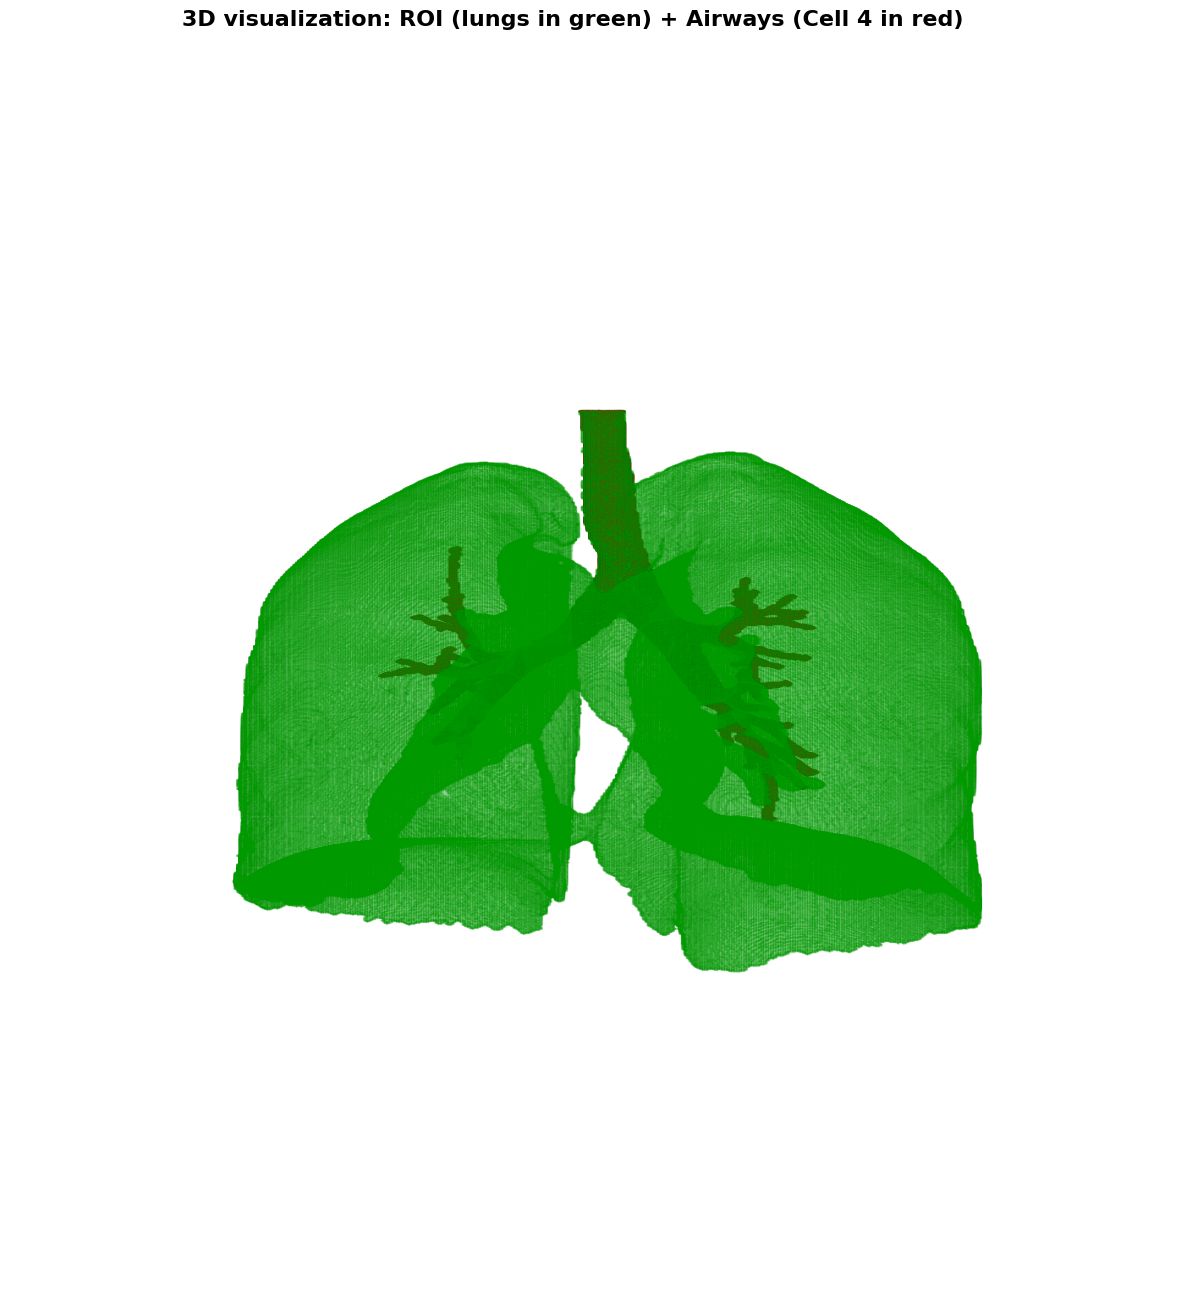

In [ ]:
# =========================
# 3D visualization of lungs (Cell 2-3 result) + airways (Cell 4 result)
# =========================
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage.measure import marching_cubes

# --- Máscaras separadas ---
lungs_mask   = final_roi.astype(bool)       # resultado Cell 2-3 (ROI pulmones+tráquea)
airways_mask = airways_mask.astype(bool)    # resultado Cell 4 (segmentación vías aéreas)

# --- Bounding box común (union de ambas) - SIN argwhere ---
def get_bounding_box_efficient(mask):
    """
    Calcula el bounding box de una máscara 3D de forma eficiente en memoria.
    """
    # Encontrar los índices donde hay al menos un True en cada "rebanada"
    # Para el eje Z (0)
    z_proj = np.any(mask, axis=(1, 2))
    z_indices = np.where(z_proj)[0]
    zmin, zmax = z_indices[0], z_indices[-1]
    
    # Para el eje Y (1)
    y_proj = np.any(mask, axis=(0, 2))
    y_indices = np.where(y_proj)[0]
    ymin, ymax = y_indices[0], y_indices[-1]
    
    # Para el eje X (2)
    x_proj = np.any(mask, axis=(0, 1))
    x_indices = np.where(x_proj)[0]
    xmin, xmax = x_indices[0], x_indices[-1]
    
    return zmin, zmax, ymin, ymax, xmin, xmax

roi_mask = np.logical_or(lungs_mask, airways_mask)
zmin, zmax, ymin, ymax, xmin, xmax = get_bounding_box_efficient(roi_mask)

# Recortar las máscaras
lungs_crop   = lungs_mask[zmin:zmax+1, ymin:ymax+1, xmin:xmax+1]
airways_crop = airways_mask[zmin:zmax+1, ymin:ymax+1, xmin:xmax+1]

# --- Espaciado físico real (Z, Y, X) ---
# Ajusta estos valores según el "Espaciado (mm)" de tu log de auditoría
spacing = (5.0, 1.0, 1.0)

# --- Malla 3D con marching cubes ---
verts_lungs, faces_lungs, _, _ = marching_cubes(lungs_crop.astype(np.float32), level=0.5, spacing=spacing)
verts_airways, faces_airways, _, _ = marching_cubes(airways_crop.astype(np.float32), level=0.5, spacing=spacing)

# --- Render 3D ---
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')

# Proyección ortográfica
try:
    ax.set_proj_type('ortho')
except Exception:
    pass

# Pulmones (verde translúcido)
mesh_lungs = Poly3DCollection(verts_lungs[faces_lungs], alpha=0.08)
mesh_lungs.set_facecolor((0.0, 0.8, 0.0))
mesh_lungs.set_edgecolor((0.0, 0.6, 0.0))
ax.add_collection3d(mesh_lungs)

# Vías aéreas (rojo translúcido)
mesh_airways = Poly3DCollection(verts_airways[faces_airways], alpha=0.3)
mesh_airways.set_facecolor((0.9, 0.2, 0.2))
mesh_airways.set_edgecolor((0.6, 0.1, 0.1))
ax.add_collection3d(mesh_airways)

# Ajustar la vista y los límites
ax.view_init(elev=0, azim=90)
# Calcular los límites en coordenadas físicas (usando el espaciado)
ax.set_xlim(verts_lungs[:, 0].min(), verts_lungs[:, 0].max())
ax.set_ylim(verts_lungs[:, 1].min(), verts_lungs[:, 1].max())
ax.set_zlim(verts_lungs[:, 2].min(), verts_lungs[:, 2].max())

ax.axis("off")
ax.grid(False)
fig.subplots_adjust(top=0.92)
plt.suptitle("3D visualization: ROI (lungs in green) + Airways (Cell 4 in red)", fontsize=16, fontweight="bold")
plt.show()

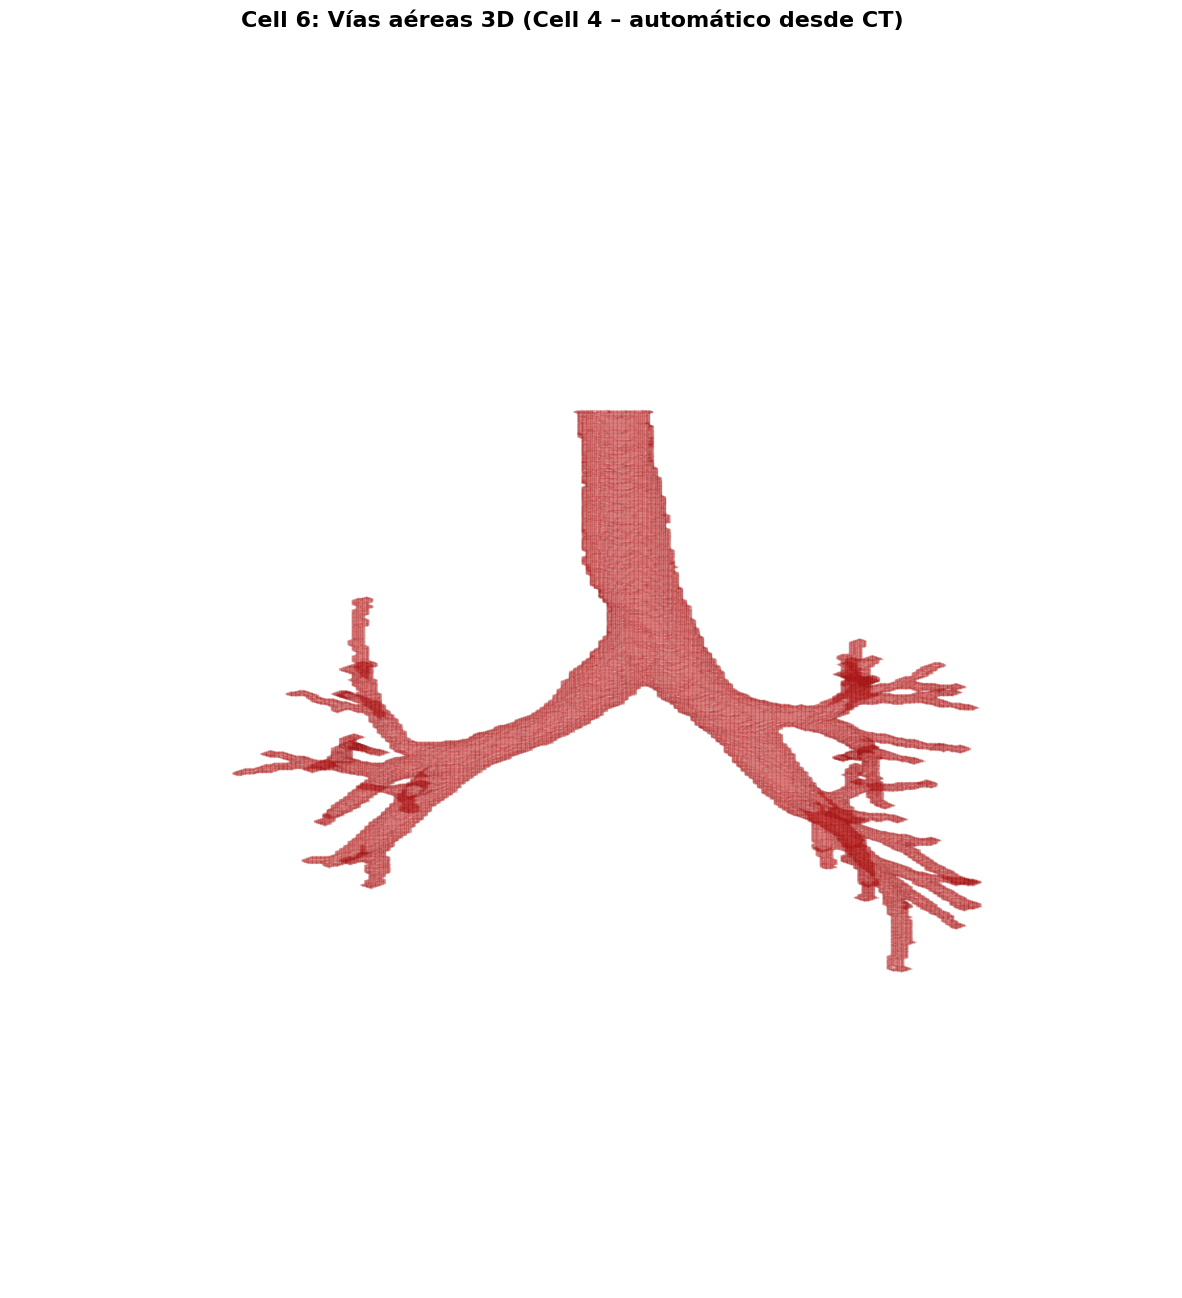

In [ ]:
# =========================
# Vías aéreas 3D completas (resultado automático de Cell 4)
# =========================
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage.measure import marching_cubes

# --- Máscara de vías aéreas desde el pipeline automático (Cell 4) ---
airways_auto = airways_mask.astype(bool)

# --- Recorte espacial (versión eficiente en memoria) ---
def get_bounding_box_efficient(mask):
    """
    Calcula el bounding box de una máscara 3D de forma eficiente.
    """
    # Eje Z (0)
    z_proj = np.any(mask, axis=(1, 2))
    z_indices = np.where(z_proj)[0]
    zmin, zmax = z_indices[0], z_indices[-1]
    
    # Eje Y (1)
    y_proj = np.any(mask, axis=(0, 2))
    y_indices = np.where(y_proj)[0]
    ymin, ymax = y_indices[0], y_indices[-1]
    
    # Eje X (2)
    x_proj = np.any(mask, axis=(0, 1))
    x_indices = np.where(x_proj)[0]
    xmin, xmax = x_indices[0], x_indices[-1]
    
    return (zmin, zmax, ymin, ymax, xmin, xmax)

zmin, zmax, ymin, ymax, xmin, xmax = get_bounding_box_efficient(airways_auto)
mask_crop = airways_auto[zmin:zmax+1, ymin:ymax+1, xmin:xmax+1]

# --- Espaciado físico real (Z, Y, X) ---
# Ajusta según el voxel spacing de tu CT si lo conoces
spacing = (5.0, 1.0, 1.0)

# --- Malla 3D con marching cubes (coordenadas físicas) ---
verts, faces, _, _ = marching_cubes(mask_crop.astype(np.float32), level=0.5, spacing=spacing)

# --- Render 3D ---
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')

# Proyección ortográfica
try:
    ax.set_proj_type('ortho')
except Exception:
    pass

# Vías aéreas (rojo semitransparente)
mesh = Poly3DCollection(verts[faces])
mesh.set_facecolor((0.9, 0.2, 0.2, 0.25))   # rojo semitransparente
mesh.set_edgecolor((0.6, 0.1, 0.1, 0.05))   # borde tenue
ax.add_collection3d(mesh)

# Cámara anatómica y límites
ax.view_init(elev=0, azim=90)
ax.set_xlim(verts[:, 0].min(), verts[:, 0].max())
ax.set_ylim(verts[:, 1].min(), verts[:, 1].max())
ax.set_zlim(verts[:, 2].min(), verts[:, 2].max())

ax.axis("off")
ax.grid(False)
fig.subplots_adjust(top=0.92)
plt.suptitle("Cell 6: Vías aéreas 3D (Cell 4 – automático desde CT)", fontsize=16, fontweight="bold")
plt.show()

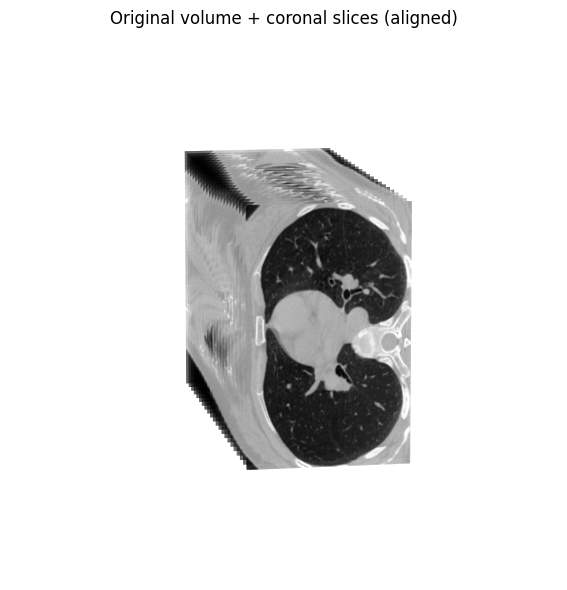

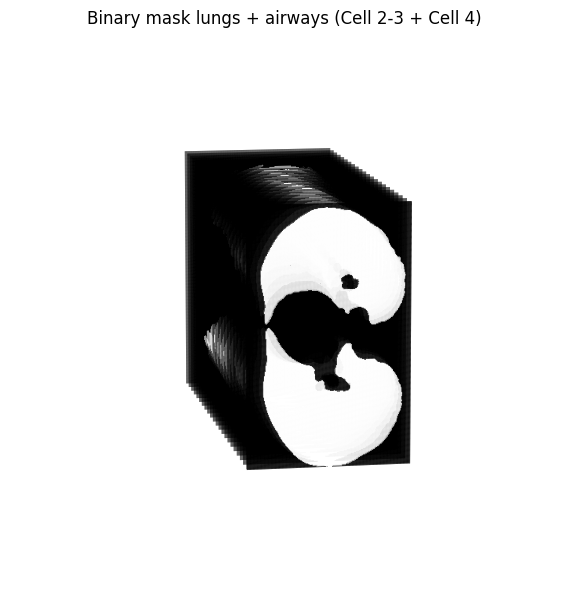

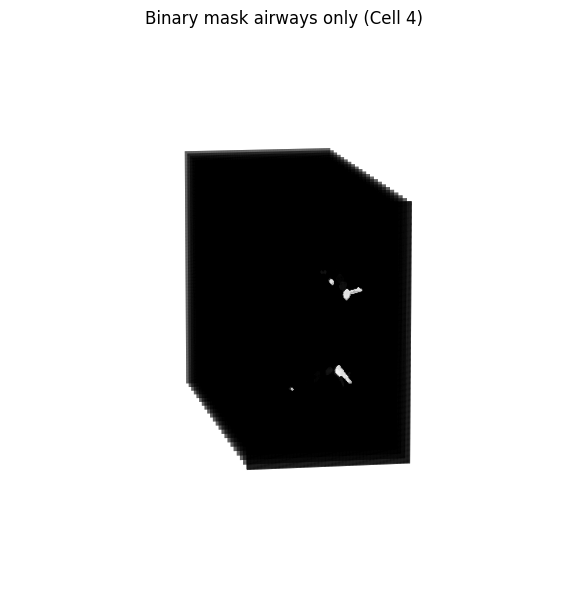

In [27]:
# =========================
# Three aligned visualizations (Cell 2-3 ROI + Cell 4 Airways)
# =========================
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

# === Combined binary ROI (lungs + automatic airways from Cell 4) ===
lungs_only   = final_roi.astype(bool)       # resultado Cell 2-3
airways_only = airways_mask.astype(bool)    # resultado Cell 4
roi_mask     = np.logical_or(lungs_only, airways_only)

# === Bounding box of ROI (versión eficiente en memoria) ===
def get_bounding_box_efficient(mask):
    """
    Calcula el bounding box de una máscara 3D de forma eficiente.
    """
    # Eje Z (0)
    z_proj = np.any(mask, axis=(1, 2))
    z_indices = np.where(z_proj)[0]
    zmin, zmax = z_indices[0], z_indices[-1]
    
    # Eje Y (1)
    y_proj = np.any(mask, axis=(0, 2))
    y_indices = np.where(y_proj)[0]
    ymin, ymax = y_indices[0], y_indices[-1]
    
    # Eje X (2)
    x_proj = np.any(mask, axis=(0, 1))
    x_indices = np.where(x_proj)[0]
    xmin, xmax = x_indices[0], x_indices[-1]
    
    return (zmin, zmax, ymin, ymax, xmin, xmax)

zmin, zmax, ymin, ymax, xmin, xmax = get_bounding_box_efficient(roi_mask)
volume_crop  = vol_clip[zmin:zmax+1, ymin:ymax+1, xmin:xmax+1]
mask_crop    = roi_mask[zmin:zmax+1, ymin:ymax+1, xmin:xmax+1]
airways_crop = airways_only[zmin:zmax+1, ymin:ymax+1, xmin:xmax+1]

# === Spatial rotation: 90° to the left (X → Y) ===
volume_rot  = np.transpose(volume_crop, axes=(0, 2, 1))[:, :, ::-1]
mask_rot    = np.transpose(mask_crop, axes=(0, 2, 1))[:, :, ::-1]
airways_rot = np.transpose(airways_crop, axes=(0, 2, 1))[:, :, ::-1]

Z, Y, X = volume_rot.shape
ymid = Y // 2

# === Robust normalization of volume ===
p2, p98 = np.percentile(volume_rot, [2, 98])
vol_norm = np.clip((volume_rot - p2) / (p98 - p2), 0, 1)

# === Function to draw slice with border and colormap ===
def draw_slice_with_border(ax, slice_2d, y, alpha=0.8, cmap=plt.cm.gray):
    ny, nx = slice_2d.shape
    X_grid, Z_grid = np.meshgrid(np.arange(nx), np.arange(ny), indexing='xy')
    Y_plane = np.full_like(X_grid, y)
    
    rgba = cmap(slice_2d)
    rgba[..., 3] = alpha
    
    ax.plot_surface(X_grid, Y_plane, Z_grid, facecolors=rgba,
                    rstride=1, cstride=1, shade=False, linewidth=0)
    
    # White border
    x0, x1 = X_grid.min(), X_grid.max()
    z0, z1 = Z_grid.min(), Z_grid.max()
    ax.plot([x0, x1, x1, x0, x0],
            [y, y, y, y, y],
            [z0, z0, z1, z1, z0],
            color='white', linewidth=2.0)

# === Colormaps for masks ===
lungs_cmap   = mcolors.ListedColormap([(0,0,0,0), (0.0, 0.8, 0.0, 0.6)])  # verde translúcido
airways_cmap = mcolors.ListedColormap([(0,0,0,0), (0.9, 0.2, 0.2, 0.6)])  # rojo translúcido

# =========================
# Original volume + coronal slices
# =========================
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

draw_slice_with_border(ax, vol_norm[:, ymid, :], ymid, alpha=1.0, cmap=plt.cm.gray)
for y in range(0, ymid, max(1, ymid // 20)):
    draw_slice_with_border(ax, vol_norm[:, y, :], y, alpha=0.8, cmap=plt.cm.gray)

ax.set_title("Original volume + coronal slices (aligned)", fontsize=12)
ax.view_init(elev=10, azim=80)
ax.set_box_aspect((X, Y, Z))
ax.axis("off"); ax.grid(False)
plt.tight_layout(); plt.show()

# =========================
# Binary mask lungs + airways (green overlay)
# =========================
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

draw_slice_with_border(ax, mask_rot[:, ymid, :].astype(float), ymid, alpha=1.0, cmap=plt.cm.gray)
for y in range(0, ymid, max(1, ymid // 20)):
    draw_slice_with_border(ax, mask_rot[:, y, :].astype(float), y, alpha=0.8, cmap=plt.cm.gray)

ax.set_title("Binary mask lungs + airways (Cell 2-3 + Cell 4)", fontsize=12)
ax.view_init(elev=10, azim=80)
ax.set_box_aspect((X, Y, Z))
ax.axis("off"); ax.grid(False)
plt.tight_layout(); plt.show()

# =========================
# Binary mask airways only (red overlay)
# =========================
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

draw_slice_with_border(ax, airways_rot[:, ymid, :].astype(float), ymid, alpha=1.0, cmap=plt.cm.gray)
for y in range(0, ymid, max(1, ymid // 20)):    
    draw_slice_with_border(ax, airways_rot[:, y, :].astype(float), y, alpha=0.8, cmap=plt.cm.gray)

ax.set_title("Binary mask airways only (Cell 4)", fontsize=12)
ax.view_init(elev=10, azim=80)
ax.set_box_aspect((X, Y, Z))
ax.axis("off"); ax.grid(False)
plt.tight_layout(); plt.show()